# This test is to be able to replicate and compare the outcomes of the original test T-003 NN Sampling, to confirm replicability and system performance across different computing hardware and python versions.

Here we evaluate the different sampling methods with a learning rate or 0.1 and 128 dense layers.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\kregh\AppData\Local\Temp\ipykernel_25396\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [9]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/smote/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [04:34<00:00, 57.92batch/s]


Epoch [1/5], Train Loss: 0.0215, Train Acc: 0.9914, Train F1: 0.9914


Epoch 2/5: 100%|██████████| 15876/15876 [04:33<00:00, 58.14batch/s]


Epoch [2/5], Train Loss: 0.0194, Train Acc: 0.9919, Train F1: 0.9919


Epoch 3/5: 100%|██████████| 15876/15876 [04:32<00:00, 58.22batch/s]


Epoch [3/5], Train Loss: 0.0196, Train Acc: 0.9919, Train F1: 0.9919


Epoch 4/5: 100%|██████████| 15876/15876 [04:28<00:00, 59.17batch/s]


Epoch [4/5], Train Loss: 0.0184, Train Acc: 0.9918, Train F1: 0.9918


Epoch 5/5: 100%|██████████| 15876/15876 [04:24<00:00, 59.92batch/s]


Epoch [5/5], Train Loss: 0.0208, Train Acc: 0.9925, Train F1: 0.9925


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 233.14batch/s]


Test Loss: 0.0214, Test Accuracy: 0.9902, Test F1: 0.9903


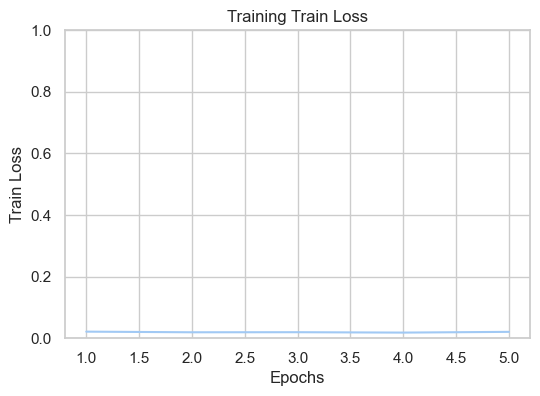

SMOTE Test


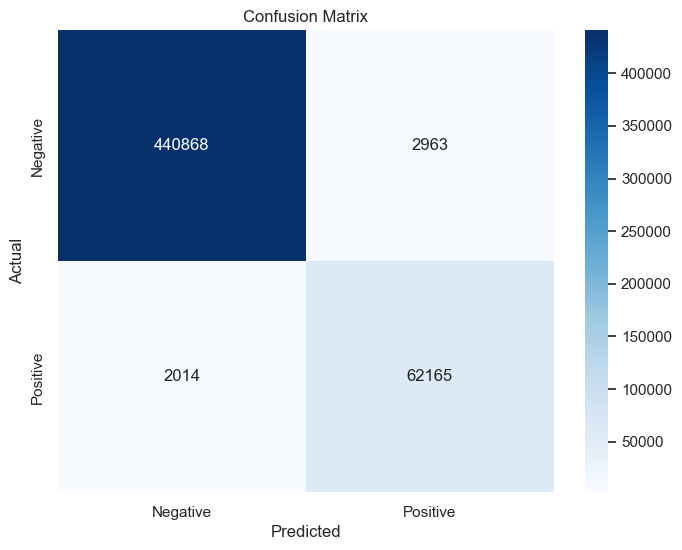

In [ ]:
# Scott - Needed to add store_data parameter value
# SC - Run Time 22m 53.7s

# 37.23 min
sampler = 'smote'
params = {'k_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('SMOTE Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [12]:
model1.load_model('./Models/saved_models/01/smote/PB_epoch_5.pth')

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:16<00:00, 243.30batch/s]


Test Loss: 0.0273, Test Accuracy: 0.9871, Test F1: 0.9875


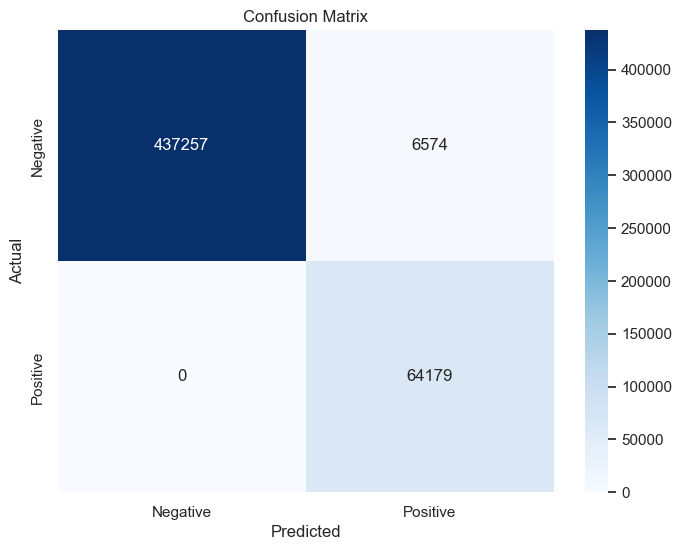

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:16<00:00, 233.72batch/s]


Test Loss: 0.0188, Test Accuracy: 0.9923, Test F1: 0.9923


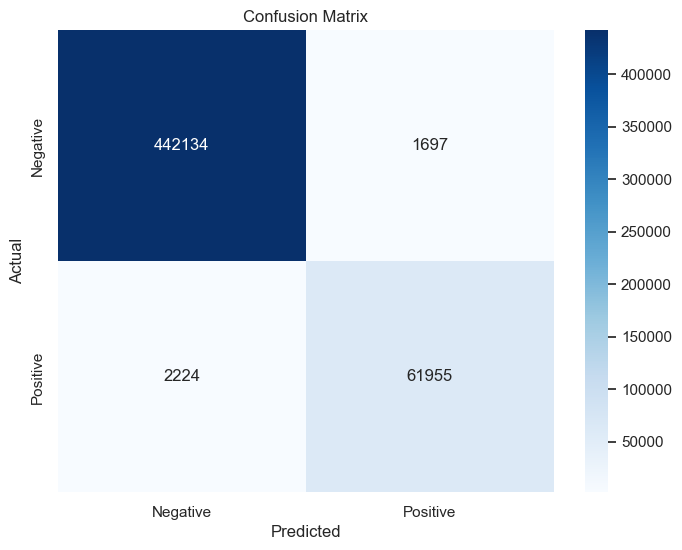

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:16<00:00, 234.18batch/s]


Test Loss: 0.0273, Test Accuracy: 0.9878, Test F1: 0.9882


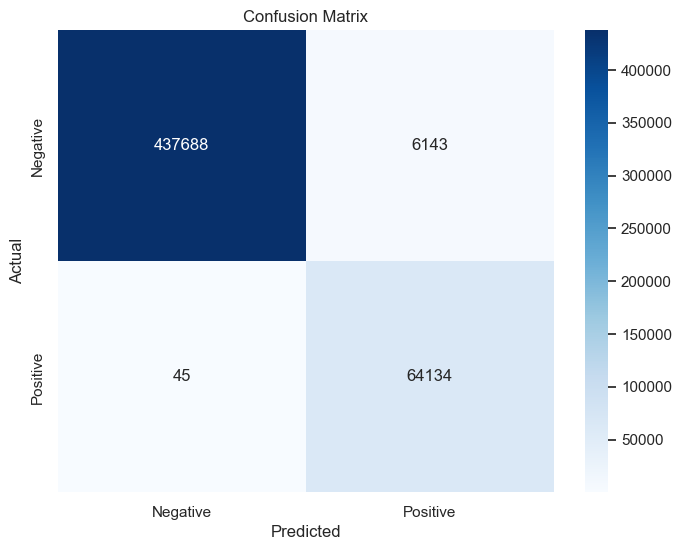

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 222.11batch/s]


Test Loss: 0.0336, Test Accuracy: 0.9875, Test F1: 0.9879


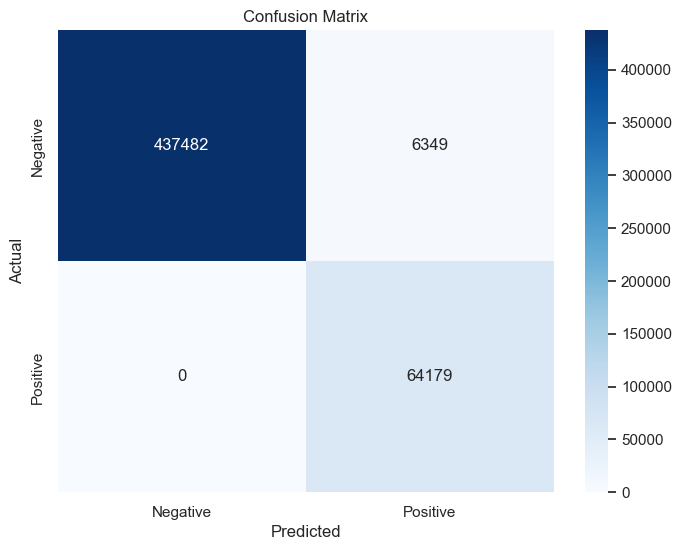

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 216.67batch/s]


Test Loss: 0.0214, Test Accuracy: 0.9902, Test F1: 0.9903


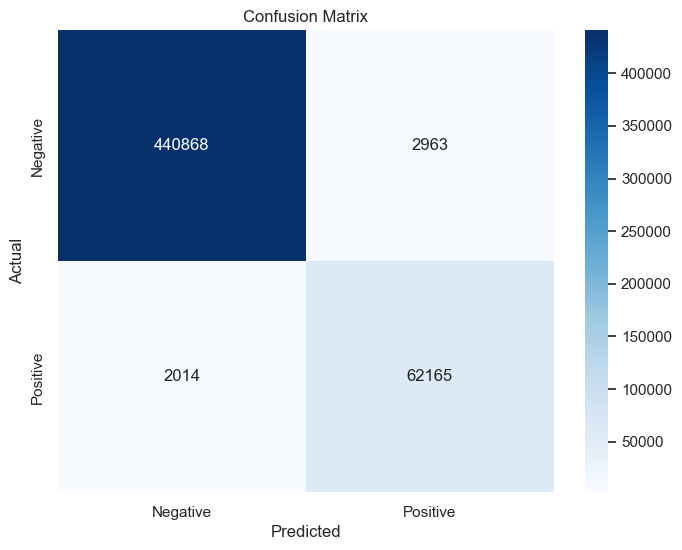

In [13]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/smote/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    y_pred = np.array(model1.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model1.test_predicted = []

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/tomeks/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [04:10<00:00, 63.35batch/s]


Epoch [1/5], Train Loss: 0.0155, Train Acc: 0.9908, Train F1: 0.9906


Epoch 2/5: 100%|██████████| 15876/15876 [04:21<00:00, 60.62batch/s]


Epoch [2/5], Train Loss: 0.0151, Train Acc: 0.9904, Train F1: 0.9902


Epoch 3/5: 100%|██████████| 15876/15876 [04:34<00:00, 57.78batch/s]


Epoch [3/5], Train Loss: 0.0146, Train Acc: 0.9908, Train F1: 0.9906


Epoch 4/5: 100%|██████████| 15876/15876 [04:35<00:00, 57.69batch/s]


Epoch [4/5], Train Loss: 0.0145, Train Acc: 0.9905, Train F1: 0.9903


Epoch 5/5: 100%|██████████| 15876/15876 [04:30<00:00, 58.62batch/s]


Epoch [5/5], Train Loss: 0.0143, Train Acc: 0.9907, Train F1: 0.9905


Testing: 100%|██████████| 3969/3969 [00:20<00:00, 197.07batch/s]


Test Loss: 0.0170, Test Accuracy: 0.9921, Test F1: 0.9919


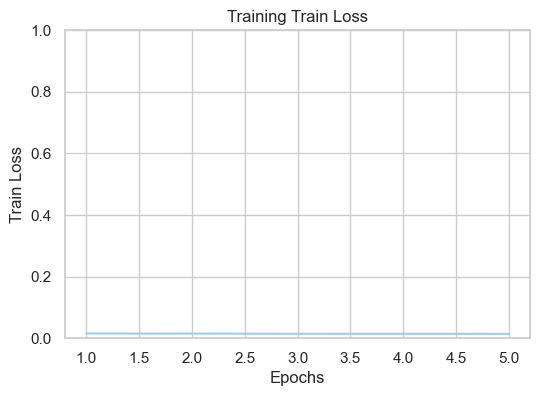

Tomeks Test


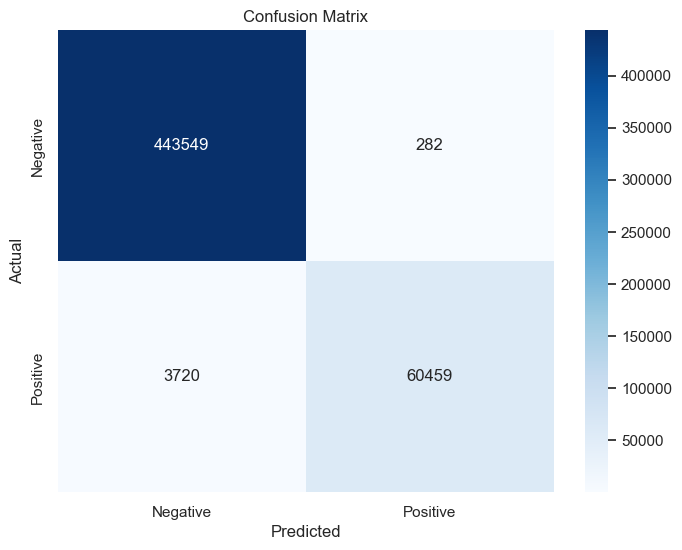

In [ ]:
# Scott - Needed to add store_data parameter value
# SC - 22m 34.4s

# 31.57 min
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model2.test(test_loader)
plot_metrics(model2.train_loss, len(model2.train_loss), title="Train Loss")
print('Tomeks Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 202.21batch/s]


Test Loss: 0.0186, Test Accuracy: 0.9902, Test F1: 0.9900


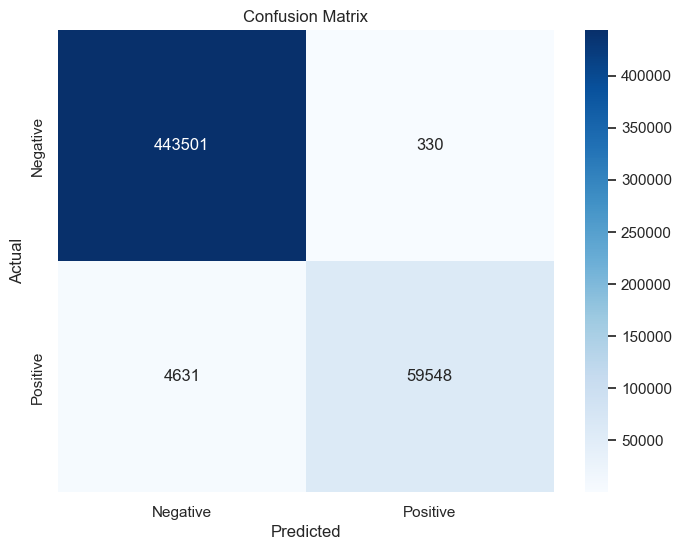

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 202.35batch/s]


Test Loss: 0.0186, Test Accuracy: 0.9916, Test F1: 0.9914


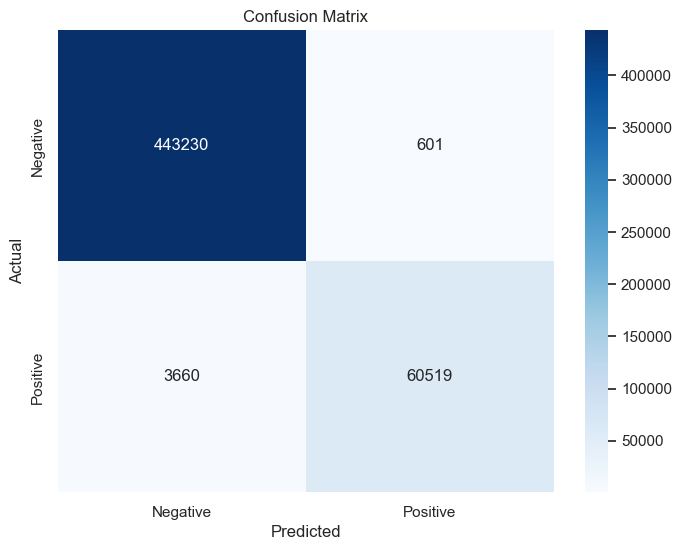

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 202.17batch/s]


Test Loss: 0.0170, Test Accuracy: 0.9905, Test F1: 0.9902


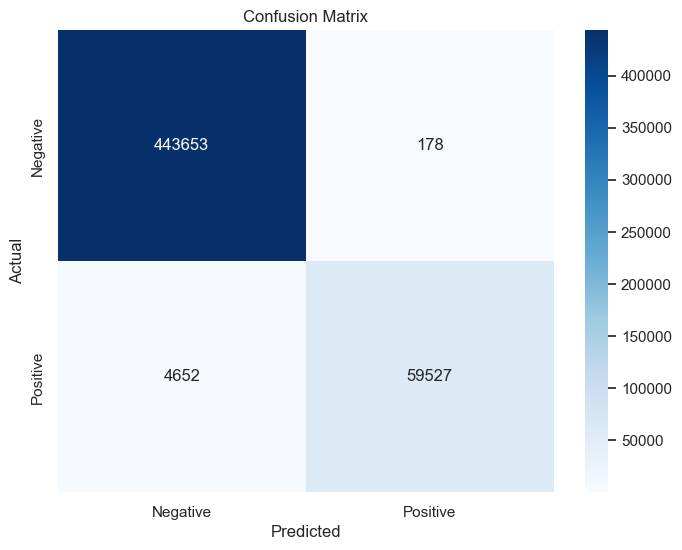

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:20<00:00, 197.56batch/s]


Test Loss: 0.0181, Test Accuracy: 0.9881, Test F1: 0.9876


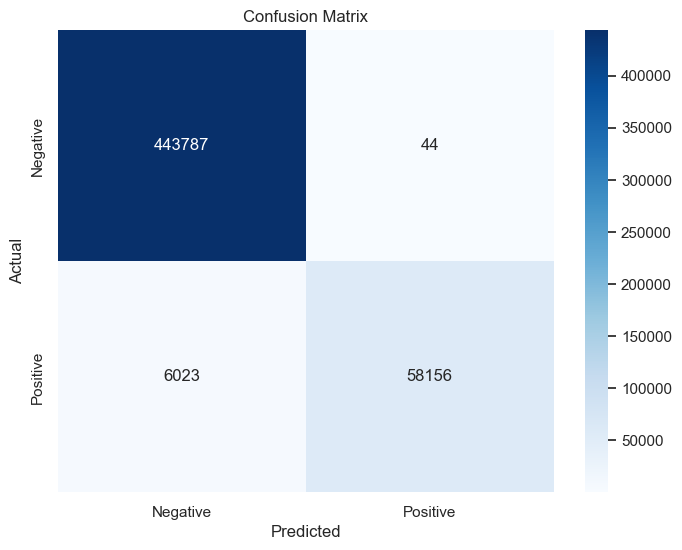

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:20<00:00, 196.20batch/s]


Test Loss: 0.0170, Test Accuracy: 0.9921, Test F1: 0.9919


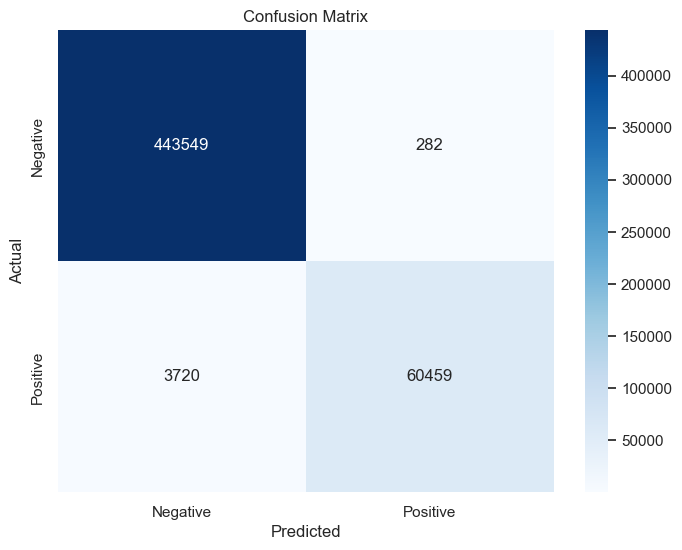

In [16]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/tomeks/PB_epoch_{i}.pth"
    model2.load_model(path)
    print(f"Epoch: {i}")
    model2.test(test_loader)
    y_pred = np.array(model2.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model2.test_predicted = []

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/edited_nearest/'
model3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [04:31<00:00, 58.56batch/s]


Epoch [1/5], Train Loss: 0.0107, Train Acc: 0.9951, Train F1: 0.9951


Epoch 2/5: 100%|██████████| 15876/15876 [04:29<00:00, 58.95batch/s]


Epoch [2/5], Train Loss: 0.0104, Train Acc: 0.9953, Train F1: 0.9954


Epoch 3/5: 100%|██████████| 15876/15876 [04:28<00:00, 59.12batch/s]


Epoch [3/5], Train Loss: 0.0110, Train Acc: 0.9954, Train F1: 0.9955


Epoch 4/5: 100%|██████████| 15876/15876 [04:25<00:00, 59.80batch/s]


Epoch [4/5], Train Loss: 0.0104, Train Acc: 0.9954, Train F1: 0.9955


Epoch 5/5: 100%|██████████| 15876/15876 [04:25<00:00, 59.85batch/s]


Epoch [5/5], Train Loss: 0.0102, Train Acc: 0.9954, Train F1: 0.9955


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 216.69batch/s]

Test Loss: 0.0222, Test Accuracy: 0.9879, Test F1: 0.9883


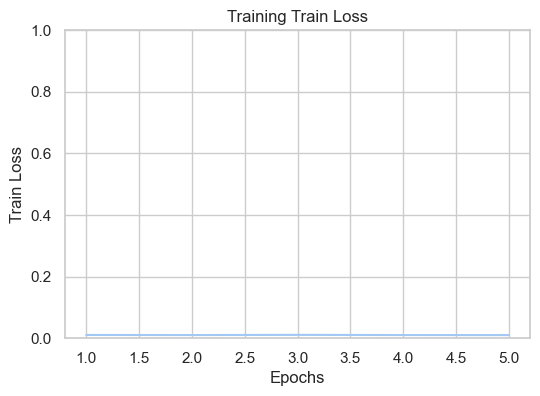

Testing: 100%|██████████| 3969/3969 [00:18<00:00, 219.45batch/s]


Test Loss: 0.0222, Test Accuracy: 0.9879, Test F1: 0.9883
Edited Nearest Test


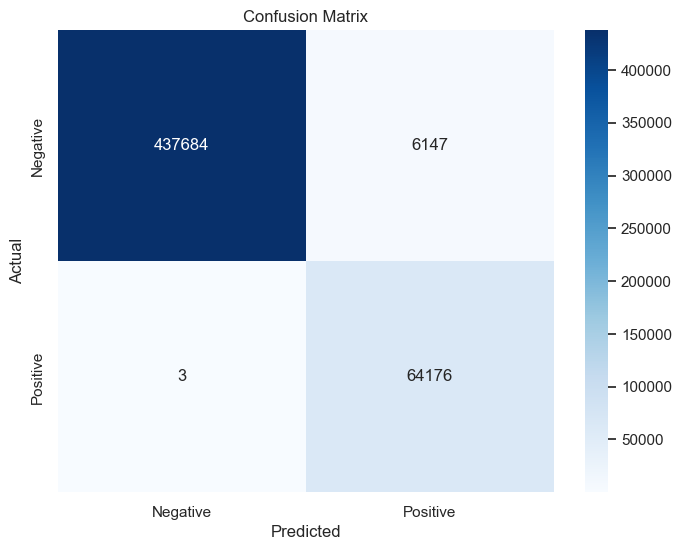

In [ ]:
# Scott - Needed to add store_data parameter value
# SC - 22m 57.0s

# 34.33 min
sampler = 'edited_nearest'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model3.test(test_loader)
plot_metrics(model3.train_loss, len(model3.train_loss), title="Train Loss")
model3.test(test_loader)
print('Edited Nearest Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model3.test_predicted)

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 205.68batch/s]


Test Loss: 0.0257, Test Accuracy: 0.9879, Test F1: 0.9882


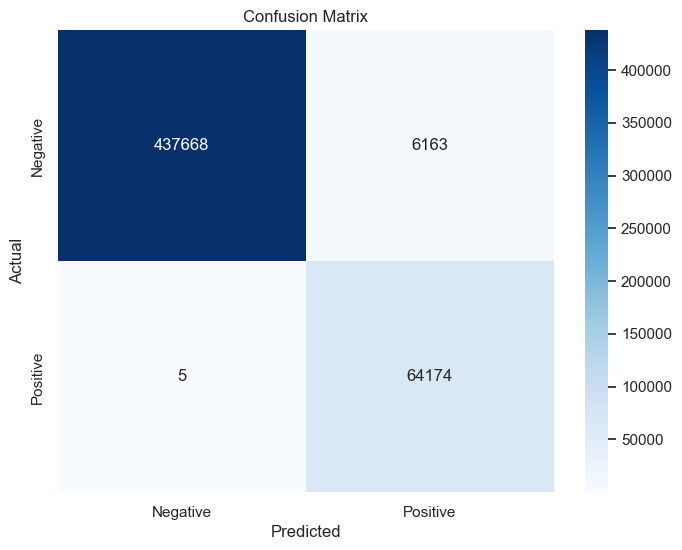

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 203.26batch/s]


Test Loss: 0.0240, Test Accuracy: 0.9879, Test F1: 0.9883


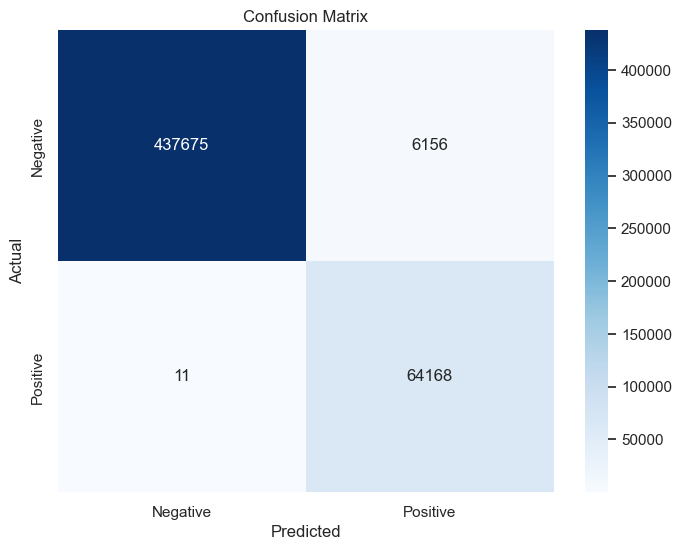

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 213.18batch/s]


Test Loss: 0.0190, Test Accuracy: 0.9878, Test F1: 0.9882


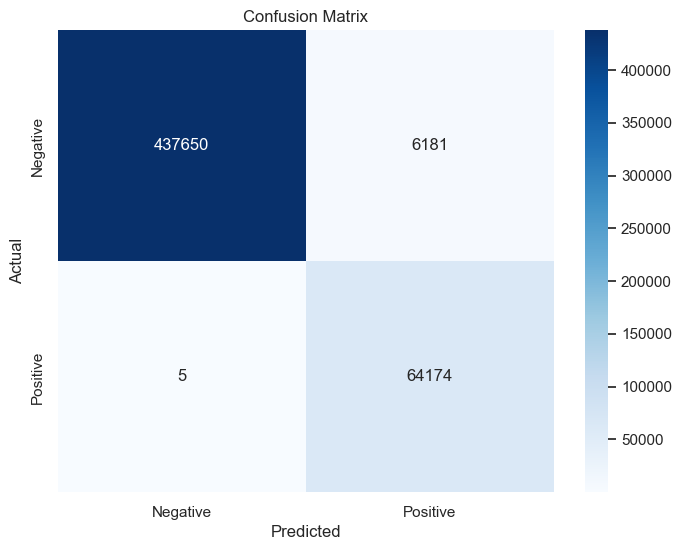

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 216.94batch/s]


Test Loss: 0.0202, Test Accuracy: 0.9879, Test F1: 0.9883


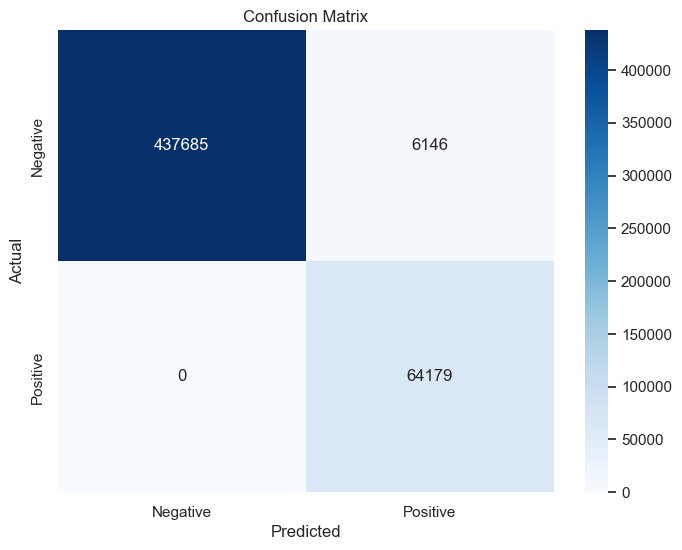

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 215.51batch/s]


Test Loss: 0.0222, Test Accuracy: 0.9879, Test F1: 0.9883


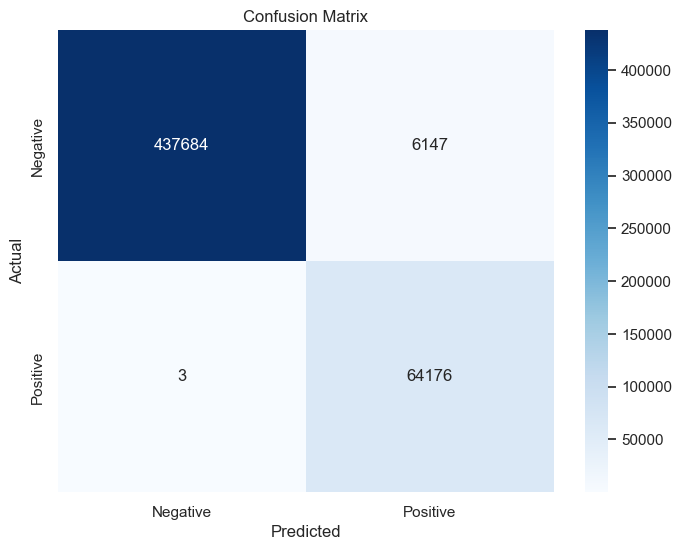

In [19]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/edited_nearest/PB_epoch_{i}.pth"
    model3.load_model(path)
    print(f"Epoch: {i}")
    model3.test(test_loader)
    y_pred = np.array(model3.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model3.test_predicted = []

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/near_miss/'
model4 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [04:21<00:00, 60.70batch/s]


Epoch [1/5], Train Loss: 0.0488, Train Acc: 0.9712, Train F1: 0.9710


Epoch 2/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.25batch/s]


Epoch [2/5], Train Loss: 0.0499, Train Acc: 0.9711, Train F1: 0.9709


Epoch 3/5: 100%|██████████| 15876/15876 [04:25<00:00, 59.84batch/s]


Epoch [3/5], Train Loss: 0.0520, Train Acc: 0.9696, Train F1: 0.9695


Epoch 4/5: 100%|██████████| 15876/15876 [04:25<00:00, 59.90batch/s]


Epoch [4/5], Train Loss: 0.0531, Train Acc: 0.9708, Train F1: 0.9707


Epoch 5/5: 100%|██████████| 15876/15876 [04:24<00:00, 59.93batch/s]


Epoch [5/5], Train Loss: 0.0528, Train Acc: 0.9708, Train F1: 0.9707


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 211.00batch/s]


Test Loss: 0.0284, Test Accuracy: 0.9839, Test F1: 0.9845


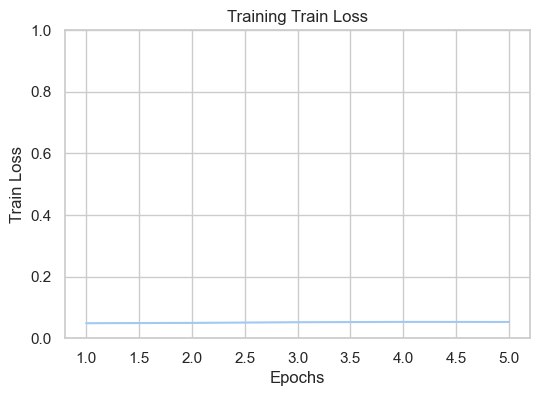

Testing: 100%|██████████| 3969/3969 [00:18<00:00, 212.60batch/s]


Test Loss: 0.0284, Test Accuracy: 0.9839, Test F1: 0.9845
Near Miss Test


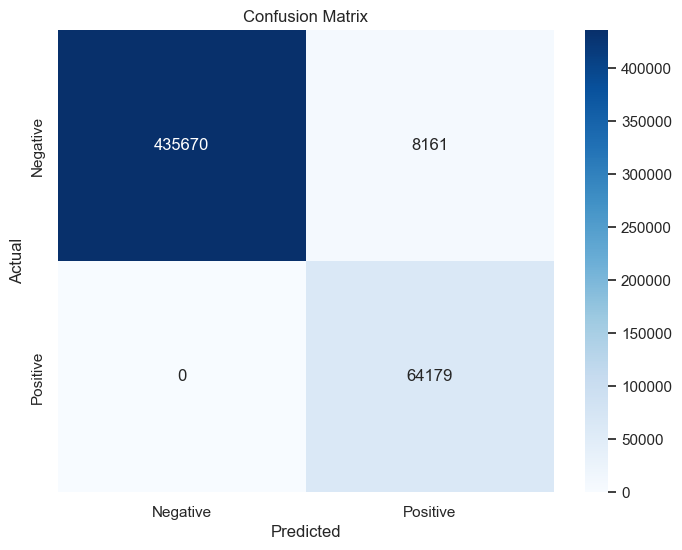

In [ ]:
# 28.54 min
# SC - 22m 43.1s


sampler = 'near_miss'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model4.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model4.test(test_loader)
plot_metrics(model4.train_loss, len(model4.train_loss), title="Train Loss")
model4.test(test_loader)
print('Near Miss Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model4.test_predicted)

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 219.13batch/s]


Test Loss: 0.1359, Test Accuracy: 0.9636, Test F1: 0.9604


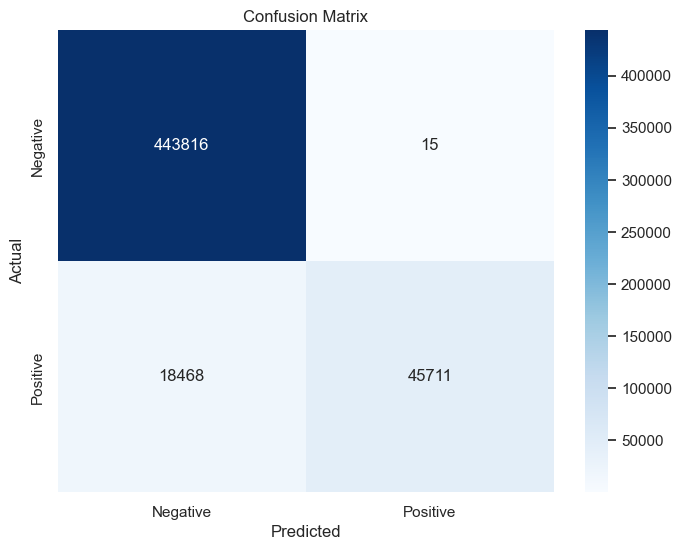

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 220.88batch/s]


Test Loss: 0.0306, Test Accuracy: 0.9841, Test F1: 0.9847


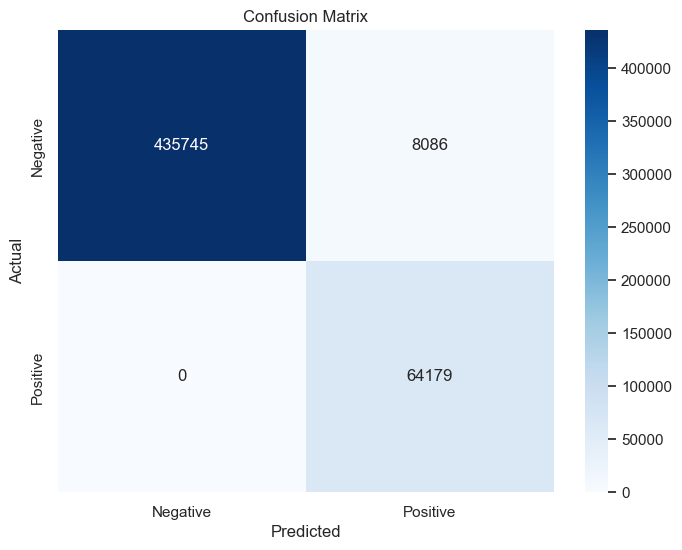

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 224.38batch/s]


Test Loss: 0.0217, Test Accuracy: 0.9909, Test F1: 0.9907


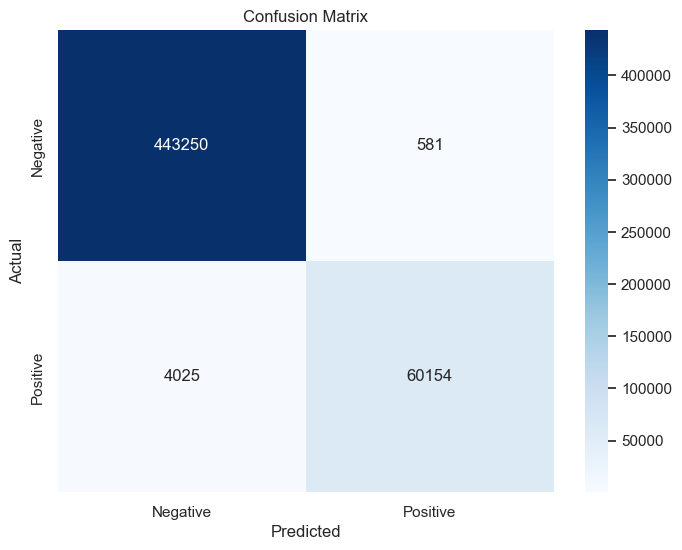

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 222.66batch/s]


Test Loss: 0.0210, Test Accuracy: 0.9911, Test F1: 0.9910


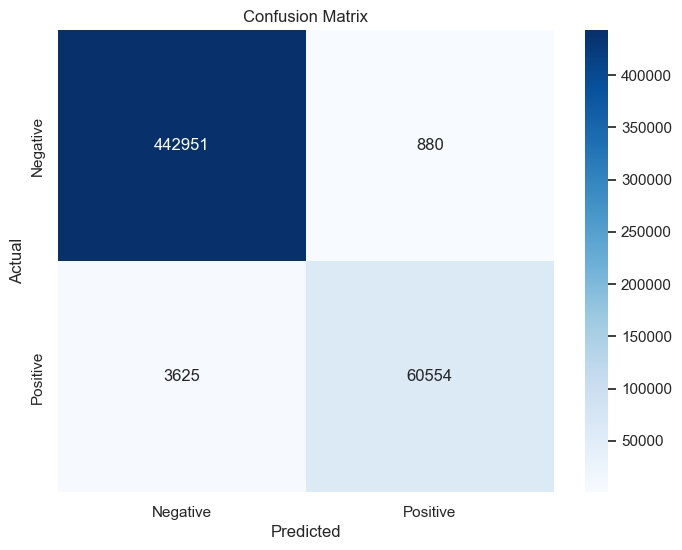

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 221.22batch/s]


Test Loss: 0.0284, Test Accuracy: 0.9839, Test F1: 0.9845


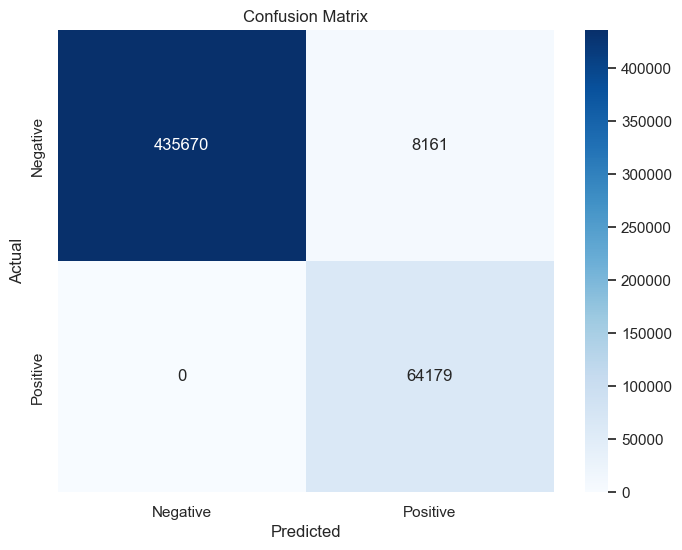

In [22]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/near_miss/PB_epoch_{i}.pth"
    model4.load_model(path)
    print(f"Epoch: {i}")
    model4.test(test_loader)
    y_pred = np.array(model4.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model4.test_predicted = []

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/one_sided_1/'
model6 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [05:34<00:00, 47.45batch/s]


Epoch [1/5], Train Loss: 0.0229, Train Acc: 0.9862, Train F1: 0.9860


Epoch 2/5: 100%|██████████| 15876/15876 [05:35<00:00, 47.26batch/s]


Epoch [2/5], Train Loss: 0.0212, Train Acc: 0.9869, Train F1: 0.9866


Epoch 3/5: 100%|██████████| 15876/15876 [05:37<00:00, 47.05batch/s]


Epoch [3/5], Train Loss: 0.0213, Train Acc: 0.9865, Train F1: 0.9863


Epoch 4/5: 100%|██████████| 15876/15876 [05:37<00:00, 47.09batch/s]


Epoch [4/5], Train Loss: 0.0212, Train Acc: 0.9863, Train F1: 0.9861


Epoch 5/5: 100%|██████████| 15876/15876 [05:35<00:00, 47.36batch/s]


Epoch [5/5], Train Loss: 0.0216, Train Acc: 0.9863, Train F1: 0.9860


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 214.64batch/s]


Test Loss: 0.0173, Test Accuracy: 0.9897, Test F1: 0.9894


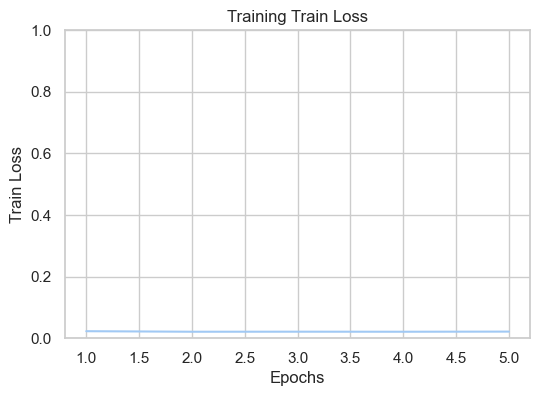

Testing: 100%|██████████| 3969/3969 [00:17<00:00, 223.35batch/s]


Test Loss: 0.0173, Test Accuracy: 0.9897, Test F1: 0.9894
One Sided Selection Test


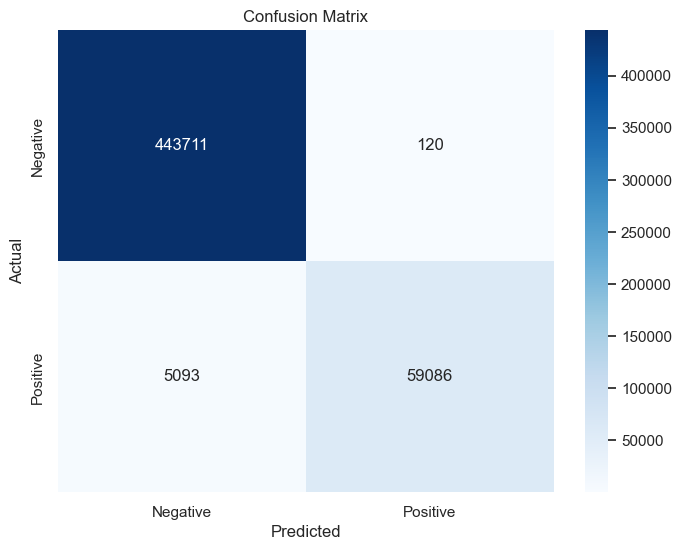

In [ ]:
# SC - 28m 37.4s


# 29.45 min
sampler = 'one_sided'
params = {'n_neighbors': None}
learning_rate = 0.1
epochs = 5
save_factor = 1
model6.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model6.test(test_loader)
plot_metrics(model6.train_loss, len(model6.train_loss), title="Train Loss")
model6.test(test_loader)
print('One Sided Selection Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model6.test_predicted)

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 213.31batch/s]


Test Loss: 0.0184, Test Accuracy: 0.9896, Test F1: 0.9893


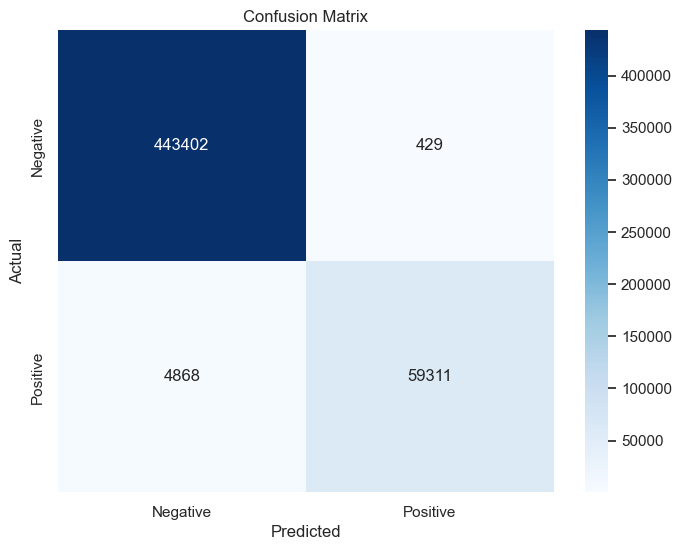

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 221.45batch/s]


Test Loss: 0.0204, Test Accuracy: 0.9878, Test F1: 0.9882


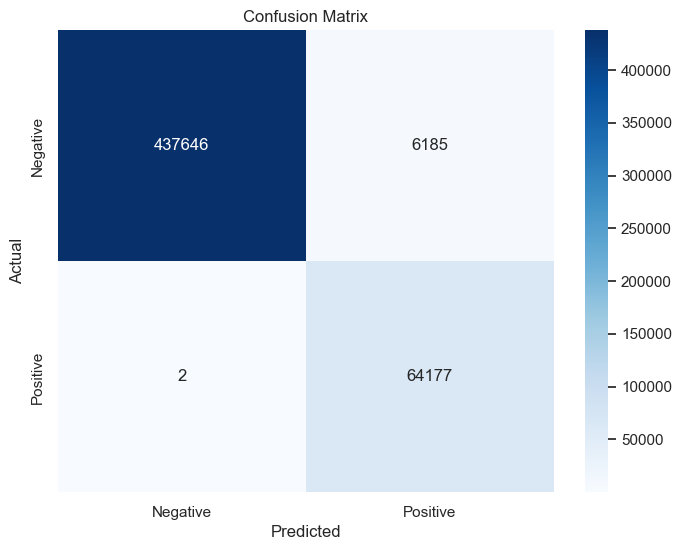

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 216.63batch/s]


Test Loss: 0.0170, Test Accuracy: 0.9921, Test F1: 0.9919


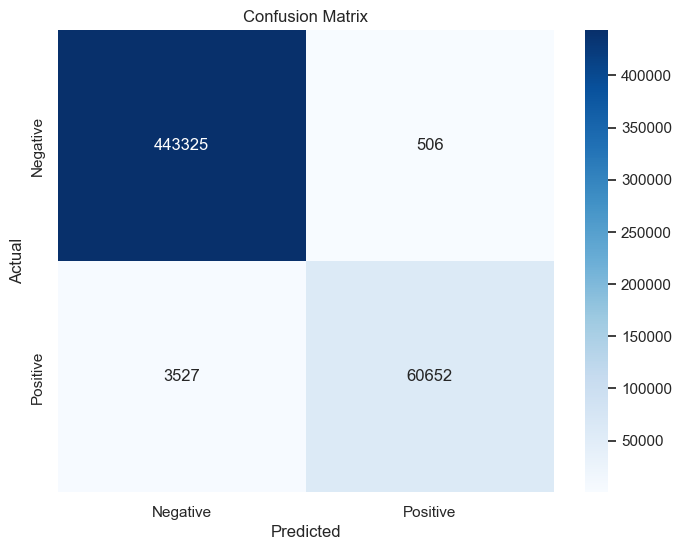

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 217.53batch/s]


Test Loss: 0.0180, Test Accuracy: 0.9909, Test F1: 0.9907


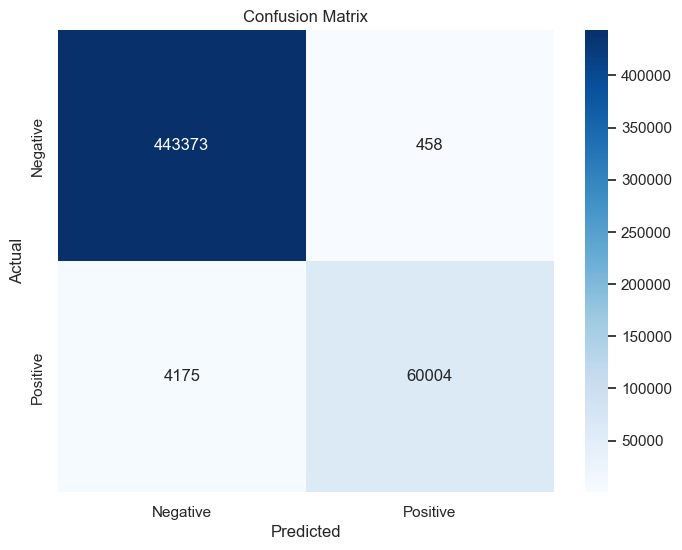

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 217.30batch/s]


Test Loss: 0.0173, Test Accuracy: 0.9897, Test F1: 0.9894


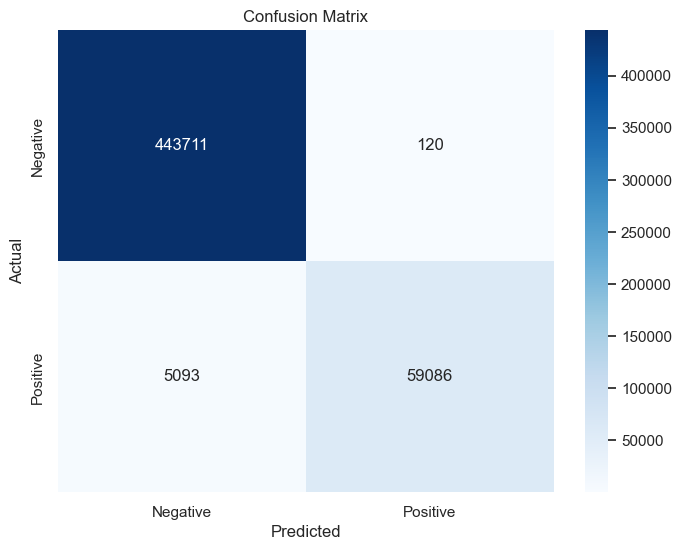

In [25]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/one_sided_1/PB_epoch_{i}.pth"
    model6.load_model(path)
    print(f"Epoch: {i}")
    model6.test(test_loader)
    y_pred = np.array(model6.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model6.test_predicted = []

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/one_sided_2/'
model7 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [05:32<00:00, 47.77batch/s]


Epoch [1/5], Train Loss: 0.0272, Train Acc: 0.9853, Train F1: 0.9850


Epoch 2/5: 100%|██████████| 15876/15876 [05:32<00:00, 47.70batch/s]


Epoch [2/5], Train Loss: 0.0245, Train Acc: 0.9859, Train F1: 0.9857


Epoch 3/5: 100%|██████████| 15876/15876 [05:32<00:00, 47.76batch/s]


Epoch [3/5], Train Loss: 0.0253, Train Acc: 0.9851, Train F1: 0.9848


Epoch 4/5: 100%|██████████| 15876/15876 [05:28<00:00, 48.27batch/s]


Epoch [4/5], Train Loss: 0.0256, Train Acc: 0.9849, Train F1: 0.9847


Epoch 5/5: 100%|██████████| 15876/15876 [05:26<00:00, 48.62batch/s]


Epoch [5/5], Train Loss: 0.0240, Train Acc: 0.9858, Train F1: 0.9855


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 216.77batch/s]

Test Loss: 0.0222, Test Accuracy: 0.9922, Test F1: 0.9921


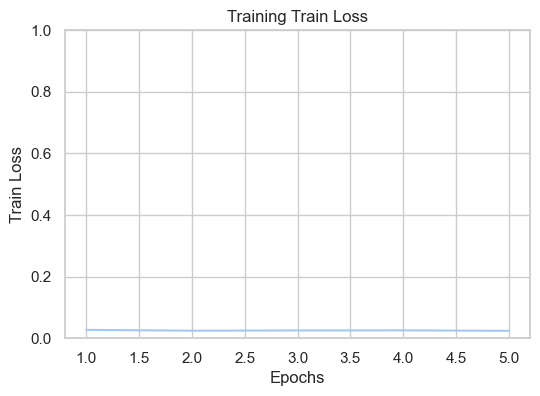

Testing: 100%|██████████| 3969/3969 [00:17<00:00, 222.66batch/s]


Test Loss: 0.0222, Test Accuracy: 0.9922, Test F1: 0.9921
One Sided Selection Test


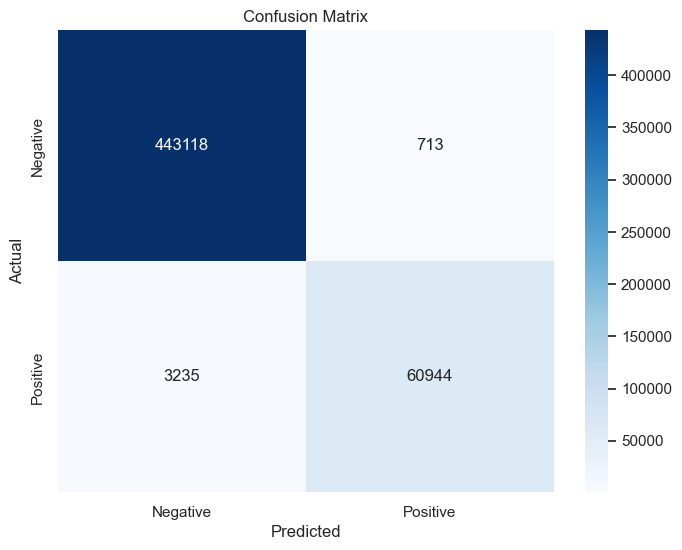

In [ ]:
# SC - 28m 10.0s


# 37.14 min
sampler = 'one_sided'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model7.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model7.test(test_loader)
plot_metrics(model7.train_loss, len(model7.train_loss), title="Train Loss")
model7.test(test_loader)
print('One Sided Selection Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model7.test_predicted)

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 216.73batch/s]


Test Loss: 0.0232, Test Accuracy: 0.9920, Test F1: 0.9919


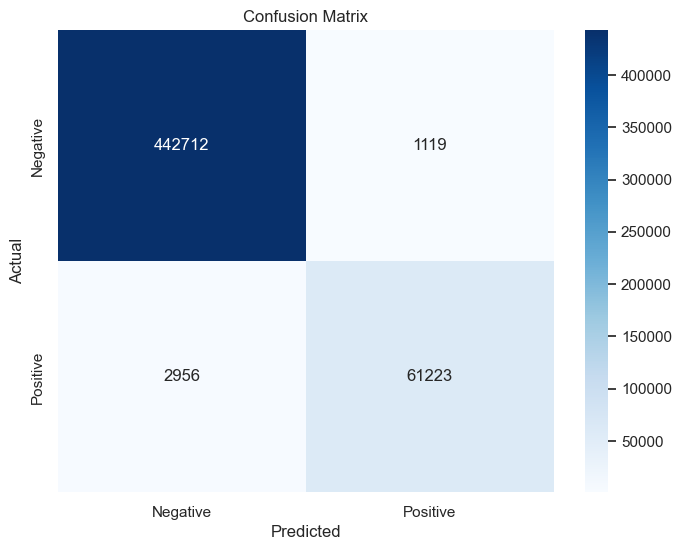

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 218.26batch/s]


Test Loss: 0.0241, Test Accuracy: 0.9913, Test F1: 0.9912


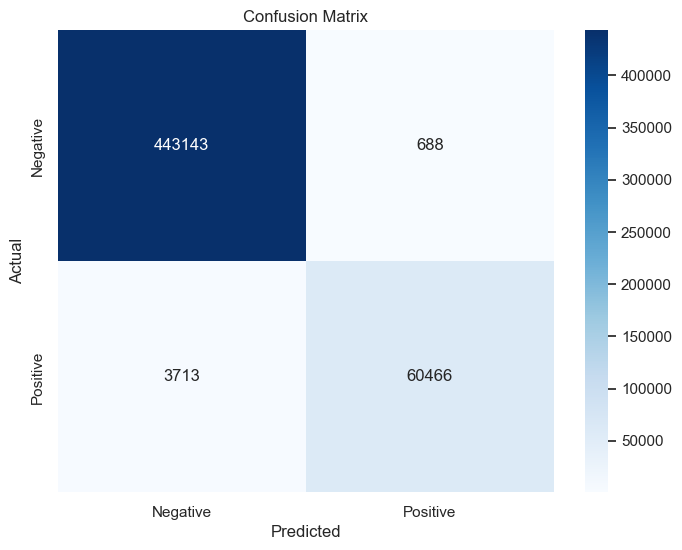

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 219.36batch/s]


Test Loss: 0.0224, Test Accuracy: 0.9921, Test F1: 0.9920


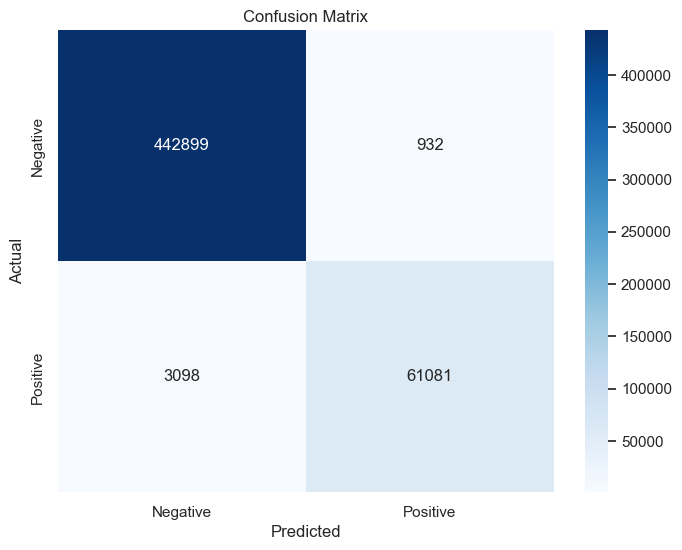

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 222.15batch/s]


Test Loss: 0.0205, Test Accuracy: 0.9887, Test F1: 0.9884


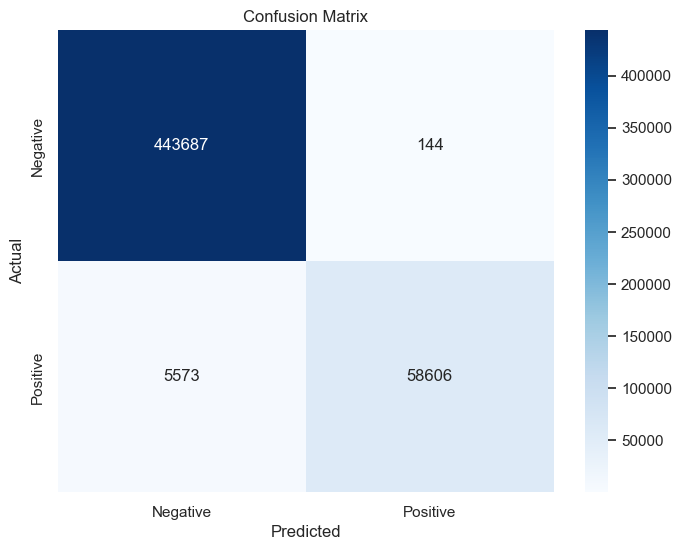

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:18<00:00, 218.71batch/s]


Test Loss: 0.0222, Test Accuracy: 0.9922, Test F1: 0.9921


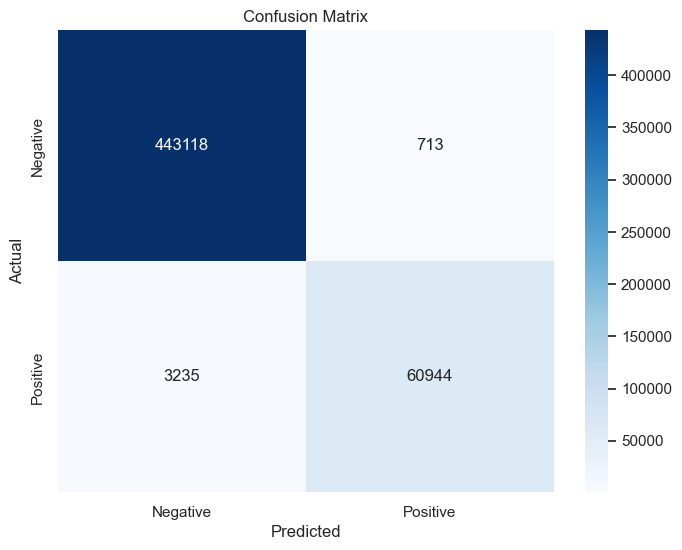

In [28]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/one_sided_2/PB_epoch_{i}.pth"
    model7.load_model(path)
    print(f"Epoch: {i}")
    model7.test(test_loader)
    y_pred = np.array(model7.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model7.test_predicted = []

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/'
model8 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [02:00<00:00, 131.62batch/s]


Epoch [1/5], Train Loss: 0.0183, Train Acc: 0.9908, Train F1: 0.9905


Epoch 2/5: 100%|██████████| 15876/15876 [02:00<00:00, 131.61batch/s]


Epoch [2/5], Train Loss: 0.0173, Train Acc: 0.9905, Train F1: 0.9902


Epoch 3/5: 100%|██████████| 15876/15876 [02:01<00:00, 131.00batch/s]


Epoch [3/5], Train Loss: 0.0171, Train Acc: 0.9909, Train F1: 0.9907


Epoch 4/5: 100%|██████████| 15876/15876 [02:01<00:00, 130.83batch/s]


Epoch [4/5], Train Loss: 0.0169, Train Acc: 0.9909, Train F1: 0.9906


Epoch 5/5: 100%|██████████| 15876/15876 [02:01<00:00, 130.97batch/s]


Epoch [5/5], Train Loss: 0.0171, Train Acc: 0.9905, Train F1: 0.9903


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 220.82batch/s]


Test Loss: 0.0168, Test Accuracy: 0.9922, Test F1: 0.9920


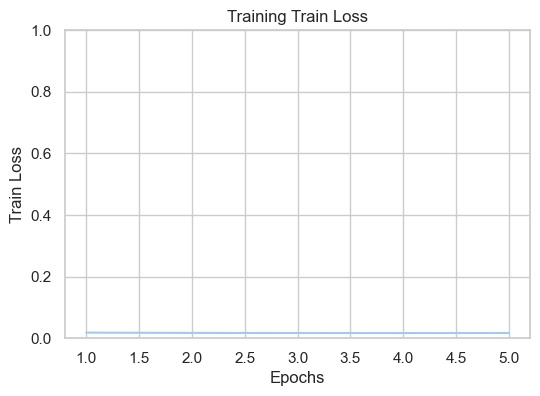

Testing: 100%|██████████| 3969/3969 [00:17<00:00, 223.00batch/s]


Test Loss: 0.0168, Test Accuracy: 0.9922, Test F1: 0.9920
Standard Test


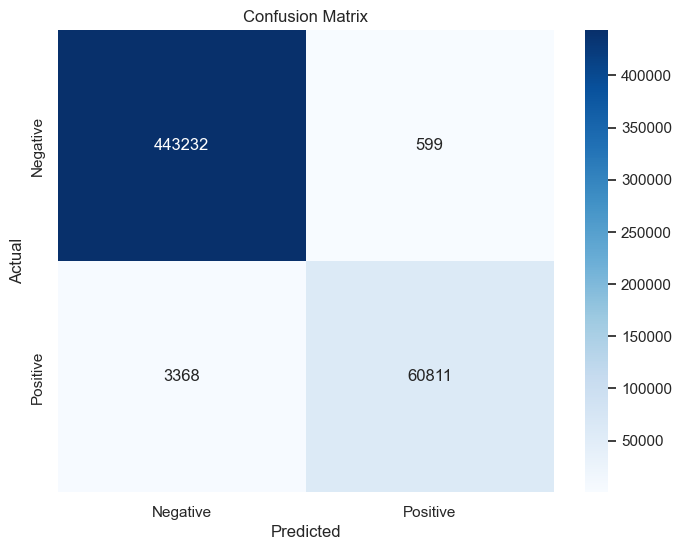

In [ ]:
# SC - 10m 41.6s


# 8.31 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
model8.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=False)
model8.test(test_loader)
plot_metrics(model8.train_loss, len(model8.train_loss), title="Train Loss")
model8.test(test_loader)
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model8.test_predicted)

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 205.88batch/s]


Test Loss: 0.0163, Test Accuracy: 0.9921, Test F1: 0.9920


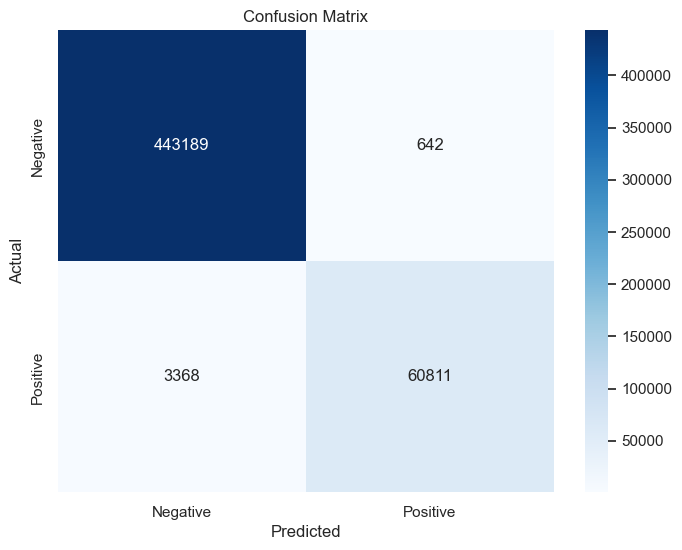

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:20<00:00, 196.26batch/s]


Test Loss: 0.0178, Test Accuracy: 0.9884, Test F1: 0.9880


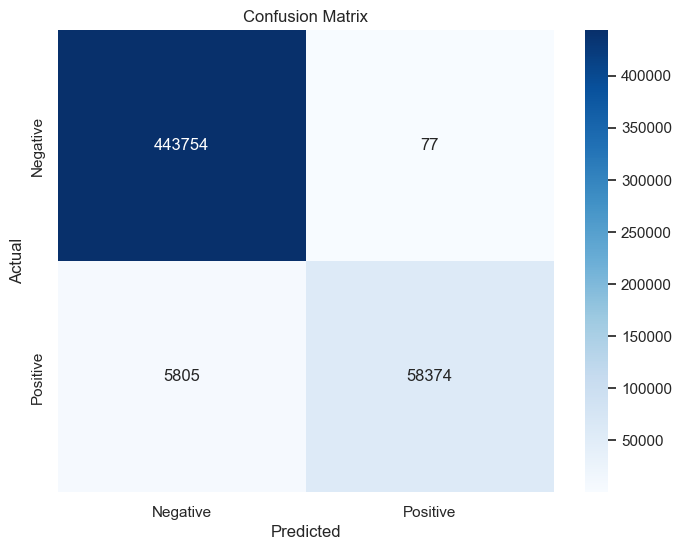

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 201.11batch/s]


Test Loss: 0.0181, Test Accuracy: 0.9901, Test F1: 0.9898


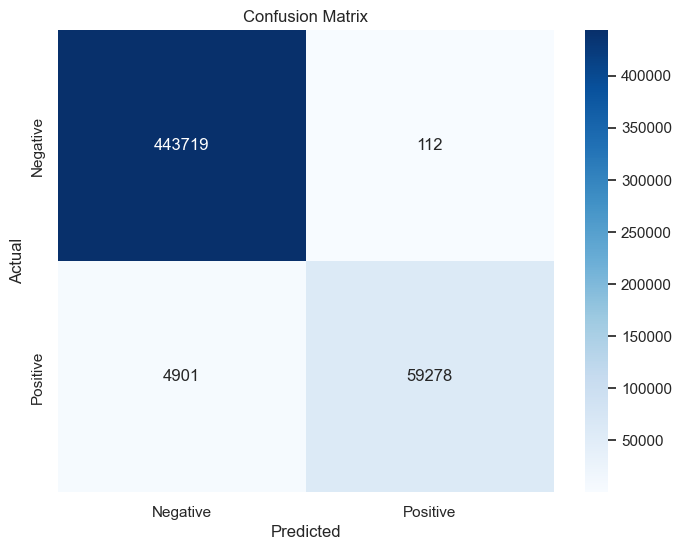

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:17<00:00, 224.42batch/s]


Test Loss: 0.0157, Test Accuracy: 0.9920, Test F1: 0.9918


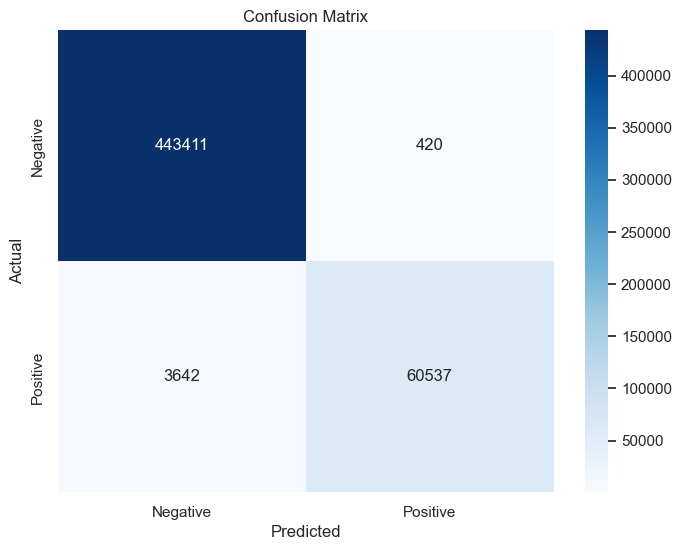

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:20<00:00, 198.39batch/s]


Test Loss: 0.0168, Test Accuracy: 0.9922, Test F1: 0.9920


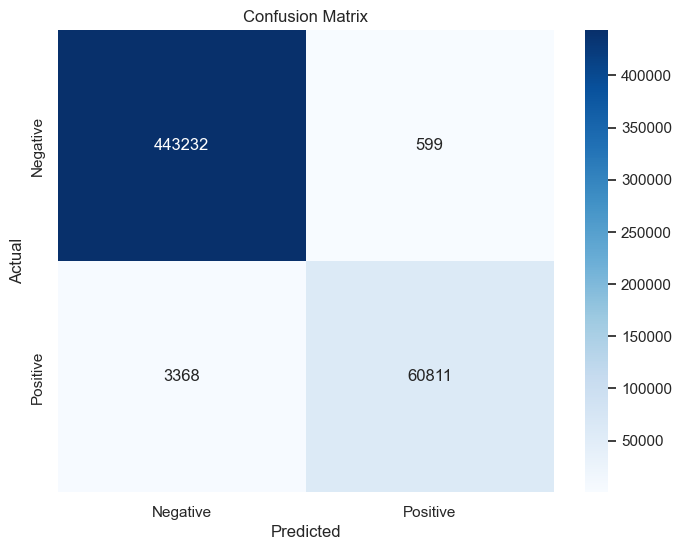

In [35]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/standard/PB_epoch_{i}.pth"
    model8.load_model(path)
    print(f"Epoch: {i}")
    model8.test(test_loader)
    y_pred = np.array(model8.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model8.test_predicted = []